In [2]:
import mlflow
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np

In [3]:
algorithms = ['PL', 'STC', 'CC', 'HLNC', 'OBNC', 'BE']

In [4]:
experiments = ['phishing_having_IP_Address', 'bank_housing', 'monks1_attr3', 'monks2_attr3', 'biodeg_V29', 
               'credit_A1', 'sick_referral_source_other', 'soil_isns', 'vote_crime', 'ads_local', 'churn_voice_mail_plan']

In [5]:
noise_types = ['random', 'flip', 'bias', 'balanced_bias']

In [6]:
# runs = {}
# for exp in experiments:
#     for alg in algorithms:
#         runs[f'{exp}_{alg}'] = mlflow.search_runs(experiment_names=[f'{exp}_{alg}'], order_by=['start_time DESC'])

runs = {}
for exp in experiments:
    for alg in algorithms:
        runs[f'{exp}_{alg}'] = pd.read_csv(f'noiseinjection_results/{exp}_{alg}.csv')

In [7]:
# for run in runs:
#     runs[run].to_csv(f'noiseinjection_results/{run}.csv', index=False)

In [8]:
for run in runs:
    runs[run] = runs[run].fillna(0)

In [9]:
metrics = [
    'accuracy',
    'roc_auc',
    'equal_opportunity_difference', 
    'predictive_equality_difference',
    'demographic_parity_difference',
    'equalized_odds_difference']

## Noise correction analysis

In [10]:
nr = [i/10 for i in range(1, 10)]
abbv = ['fpr', 'fnr']
names = ['false positive', 'false negative']

In [11]:
def show_correction_performance(noise_type):
    fig = plt.figure(figsize=(12, 4))
    axs = fig.subplots(1, 2, sharey=True)

    for i in range(2):
        for alg in algorithms:
            values = []
            for noise_rate in nr:
                avg_value = []
                for exp in experiments:
                    run = runs[f'{exp}_{alg}']
                    avg_value.append(run.loc[(run['params.noise_type'] == noise_type) & (run['params.noise_rate'] == noise_rate)][f'metrics.correction_{abbv[i]}'].mean())
                values.append(np.mean(avg_value))

            axs[i].plot(nr, values, label=alg)
        axs[i].set_xlabel('Noise rate')
        axs[i].set_title(f'% of {names[i]} labels after correction')
        axs[i].legend()

    plt.show()

In [12]:
def show_correction_similarity(noise_type):
    fig = plt.figure(figsize=(6, 4))

    for alg in algorithms:
        values = []
        for noise_rate in nr:
            avg_value = []
            for exp in experiments:
                run = runs[f'{exp}_{alg}']
                avg_value.append(run.loc[(run['params.noise_type'] == noise_type) & (run['params.noise_rate'] == noise_rate)][f'metrics.correction_acc'].mean())
            values.append(np.mean(avg_value))

        plt.plot(nr, values, label=alg)
    plt.xlabel('Noise rate')
    plt.ylabel('Similarity (% of correct labels)')
    plt.title('Similarity to original labels after correction')
    plt.legend()

    plt.show()

In [13]:
def compare_noise_types(metric):
    fig = plt.figure(figsize=(15, 6))
    axs = fig.subplots(2, 3, sharey=True)
    fig.tight_layout(pad=3.0)

    for i in range(6):
        alg = algorithms[i]
        row = i // 3
        col = i % 3
        for noise_type in noise_types:
            values = []
            for noise_rate in nr:
                avg_value = []
                for exp in experiments:
                    run = runs[f'{exp}_{alg}']
                    avg_value.append(run.loc[(run['params.noise_type'] == noise_type) & (run['params.noise_rate'] == noise_rate)][f'metrics.correction_{metric}'].mean())
                values.append(np.mean(avg_value))
            
            axs[row, col].plot(nr, values, label=noise_type)
        axs[row, col].set_xlabel('Noise rate')
        axs[row, col].set_title(f'Noise correction algorithm: {alg}')

    axs[1, 2].legend()
    plt.show()

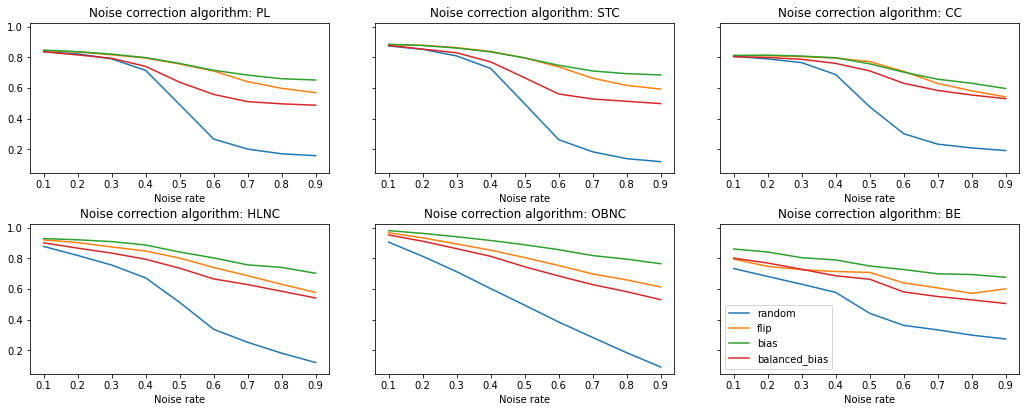

In [14]:
compare_noise_types('acc')

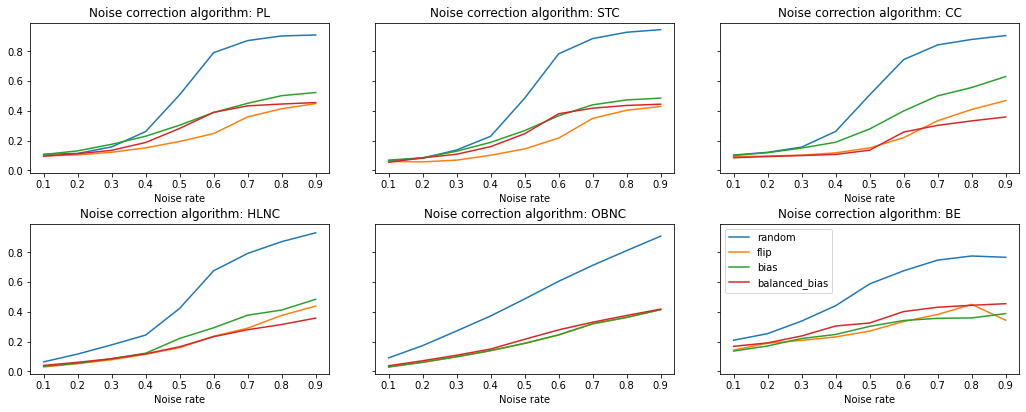

In [15]:
compare_noise_types('fpr')

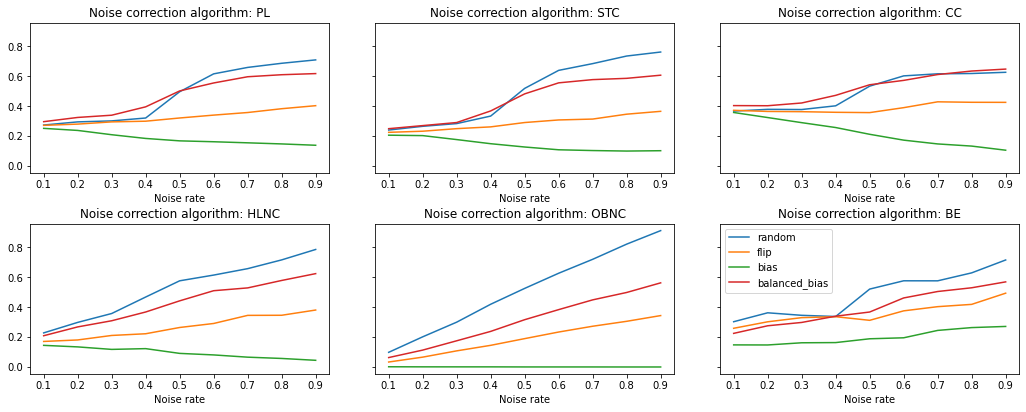

In [16]:
compare_noise_types('fnr')

### Noise type: random noise

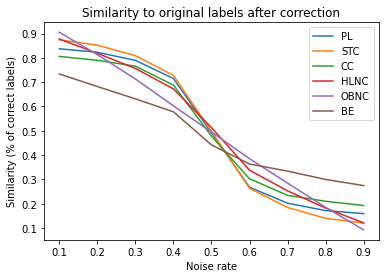

In [17]:
show_correction_similarity('random')

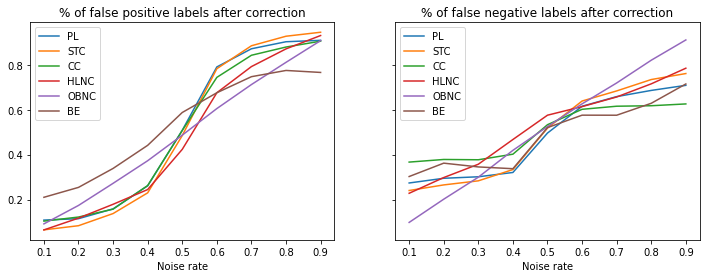

In [18]:
show_correction_performance('random')

### Noise type: instance-dependant label flipping

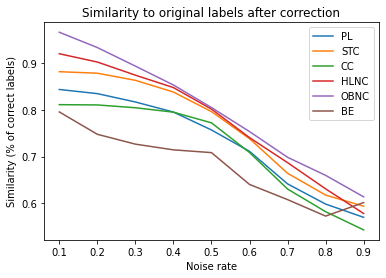

In [19]:
show_correction_similarity('flip')

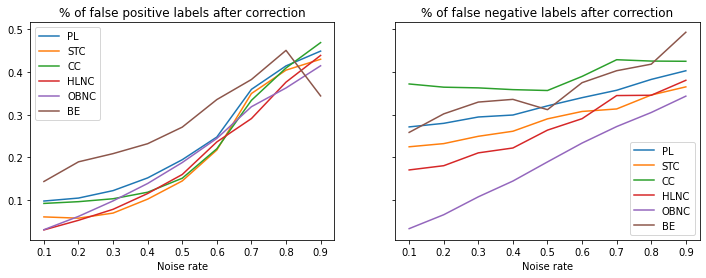

In [20]:
show_correction_performance('flip')

### Noise type: positive group bias

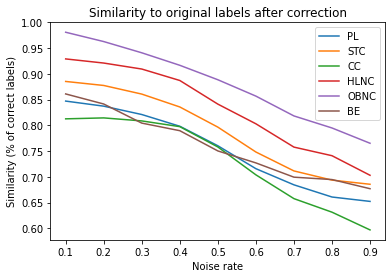

In [21]:
show_correction_similarity('bias')

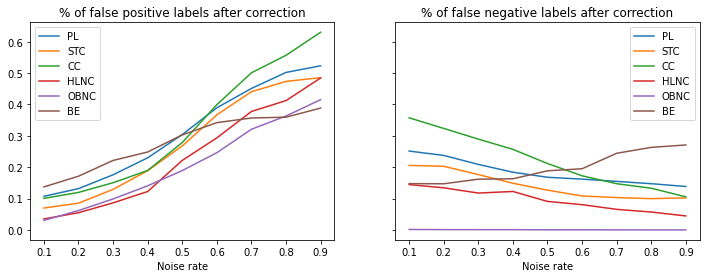

In [22]:
show_correction_performance('bias')

### Noise type: balanced group bias

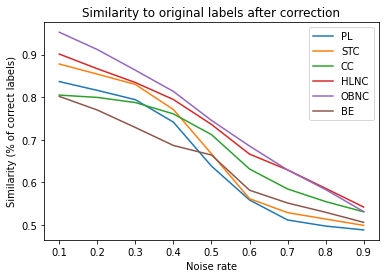

In [23]:
show_correction_similarity('balanced_bias')

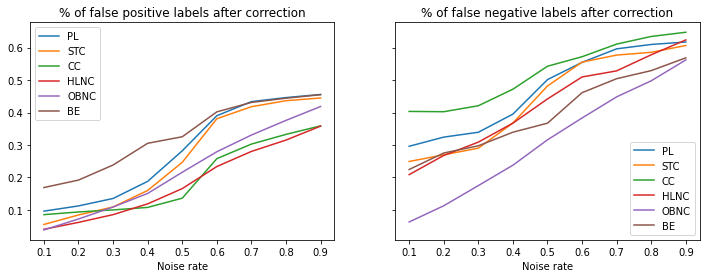

In [24]:
show_correction_performance('balanced_bias')

### Notes

- FNR para OBNC é sempre 0 -> "corrigir" tudo para positivo?

# Predictive performance comparison

In [25]:
def show_metric(exp, noise_type, test_set, metric, ax):
    run = runs[f'{exp}_PL']
    run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
    if test_set == 'original':
        ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'original')][f'metrics.{metric}'].values[0] for noise_rate in nr], label='original', color='black', linestyle='--', linewidth=2)
    ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0] for noise_rate in nr], label='noisy', color='r', linestyle='--',linewidth=2)

    for alg in algorithms:
        run = runs[f'{exp}_{alg}']
        run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
        ax.plot(nr, [run.loc[(run['params.noise_rate'] == f'{noise_rate}') & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0] for noise_rate in nr], label=alg)

    ax.set_title(f'{test_set} test set')
    ax.set_xlabel('Noise rate')
    ax.set_ylabel(f'{metric}')

In [26]:
def show_all_test_sets(exp, noise_type, metric):
    fig = plt.figure(figsize=(20, 4))
    axs = fig.subplots(1, 3, sharey=True)
    test_sets = ['original', 'noisy', 'corrected']

    for i in range(3):
        show_metric(exp, noise_type, test_sets[i], metric, axs[i])

    
    axs[2].legend(bbox_to_anchor=(1, 1))
    plt.suptitle(f'{exp} - {metric} comparison ({noise_type} noise)', fontsize=16, y=1.05)
    plt.show()

In [27]:
def show_metric_aggregated(noise_type, test_set, metric, ax, title):
    #ax.set_ylim([0, 1])
    results = {alg: {noise_rate: [] for noise_rate in nr} for alg in algorithms}
    results['noisy'] = {noise_rate: [] for noise_rate in nr}
    if test_set == 'original':
        results['original'] = {noise_rate: [] for noise_rate in nr}

    for exp in experiments:
        run = runs[f'{exp}_PL']
        run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
        for noise_rate in nr:
            results['noisy'][noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0])
            if test_set == 'original':
                results['original'][noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'original')][f'metrics.{metric}'].values[0])
        for alg in algorithms:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
            for noise_rate in nr:
                results[alg][noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])

    if test_set == 'original':       
        ax.plot(nr, [np.mean(results['original'][noise_rate]) for noise_rate in nr], label='original', color='black', linestyle='--', linewidth=2)
    ax.plot(nr, [np.mean(results['noisy'][noise_rate]) for noise_rate in nr], label='noisy', color='r', linestyle='--',linewidth=2)

    for alg in algorithms:
        ax.plot(nr, [np.mean(results[alg][noise_rate]) for noise_rate in nr], label=alg)

    ax.set_title(title)
    ax.set_xlabel('Noise rate')
    #ax.set_ylabel(f'{metric}')

In [28]:
def show_all_test_sets_aggr(noise_type, metric):
    fig = plt.figure(figsize=(18, 5))
    axs = fig.subplots(1, 2, sharey=True)
    test_sets = ['original', 'noisy']

    for i in range(2):
        show_metric_aggregated(noise_type, test_sets[i], metric, axs[i], f'{test_sets[i]} test set')

    
    axs[0].legend(bbox_to_anchor=(2.5, 1))
    plt.suptitle(f'{metric} comparison ({noise_type} noise)', fontsize=16, y=1.05)
    plt.show()

In [29]:
pred_metrics = ['accuracy', 'roc_auc']

In [30]:
def show_all_metrics_pred(noise_type, test_set):
    fig = plt.figure(figsize=(14, 4))
    axs = fig.subplots(1, 2, sharey=True)

    for i in range(2):
        show_metric_aggregated(noise_type, test_set, pred_metrics[i], axs[i], f'{pred_metrics[i]}')

    
    axs[0].legend(bbox_to_anchor=(2.5, 1))
    plt.show()

In [31]:
fair_metrics = [
        'equal_opportunity_difference', 
        'predictive_equality_difference',
        'demographic_parity_difference',
        'equalized_odds_difference']

In [32]:
def show_all_metrics_fair(noise_type, test_set):
    fig = plt.figure(figsize=(23, 4))
    axs = fig.subplots(1, 4, sharey=True)
    

    for i in range(4):
        show_metric_aggregated(noise_type, test_set, fair_metrics[i], axs[i], f'{fair_metrics[i]}')

    
    axs[0].legend(bbox_to_anchor=(4.5, 1))
    plt.subplots_adjust(wspace=0.07)
    plt.show()

In [33]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

def show_corrected_test_performance(noise_type, metric):
    fig = plt.figure(figsize=(18, 6))
    axs = fig.subplots(2, 3, sharey=True, sharex=True)

    for i in range(6):
        row = i // 3
        col = i % 3
        alg = algorithms[i]

        results = {noise_rate: [] for noise_rate in nr}
        results_original = {noise_rate: [] for noise_rate in nr}

        for exp in experiments:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == 'corrected')]
            for noise_rate in nr:
                results[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == 'original')]
            for noise_rate in nr:
                results_original[noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')][f'metrics.{metric}'].values[0])
            
        axs[row, col].plot(nr, [np.mean(results_original[noise_rate]) for noise_rate in nr], label='original test set', color='black', linestyle='--', linewidth=2)
        axs[row, col].plot(nr, [np.mean(results[noise_rate]) for noise_rate in nr], label=f'{alg} corrected test set', color=colors[i])

        axs[row, col].set_xlabel('Noise rate')
        axs[row, col].set_ylabel(f'{metric}')

        axs[row, col].legend()
    plt.show()

## Comparing on a single dataset

In [34]:
dataset = 'bank_housing'

### Flip noise (only evaluating predictive performance)

IndexError: index 0 is out of bounds for axis 0 with size 0

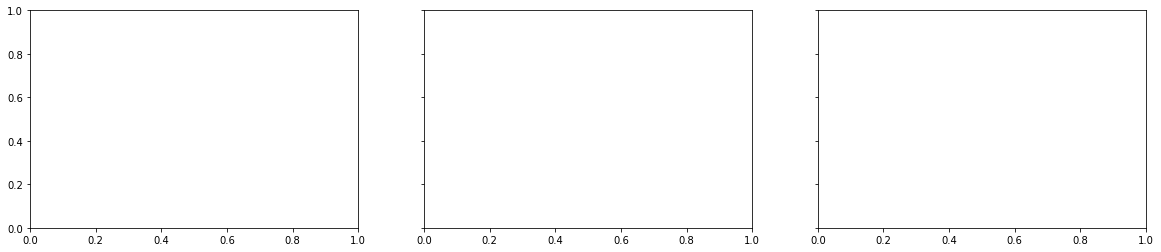

In [35]:
show_all_test_sets(dataset, 'flip', 'roc_auc')
show_all_test_sets(dataset, 'flip', 'accuracy')

### Group bias noise

In [ ]:
#show_all_test_sets(dataset, 'bias', 'roc_auc')
#show_all_test_sets(dataset, 'bias', 'accuracy')

In [ ]:
# show_all_test_sets(dataset, 'bias', 'demographic_parity_difference')
# show_all_test_sets(dataset, 'bias', 'equal_opportunity_difference')
# show_all_test_sets(dataset, 'bias', 'equalized_odds_difference')
# show_all_test_sets(dataset, 'bias', 'predictive_equality_difference')

## Aggregated data

### Random noise

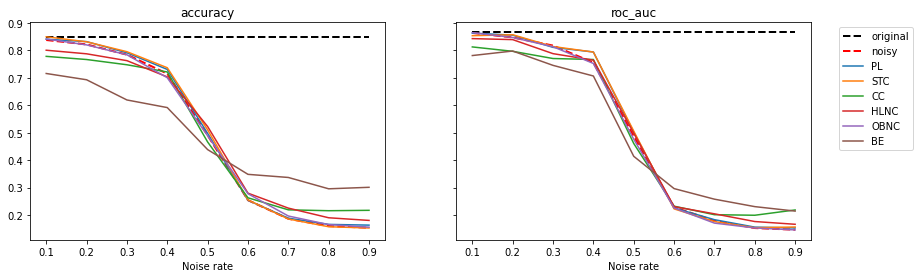

In [ ]:
show_all_metrics_pred('random', 'original')

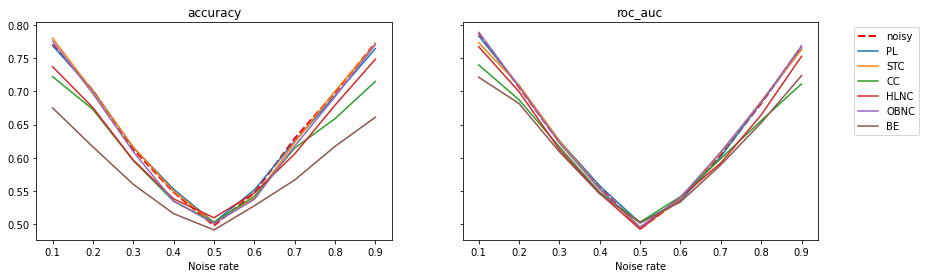

In [ ]:
show_all_metrics_pred('random', 'noisy')

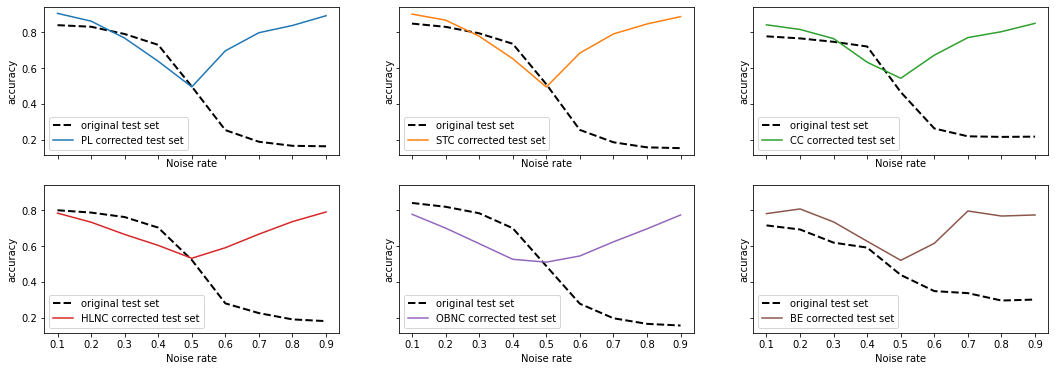

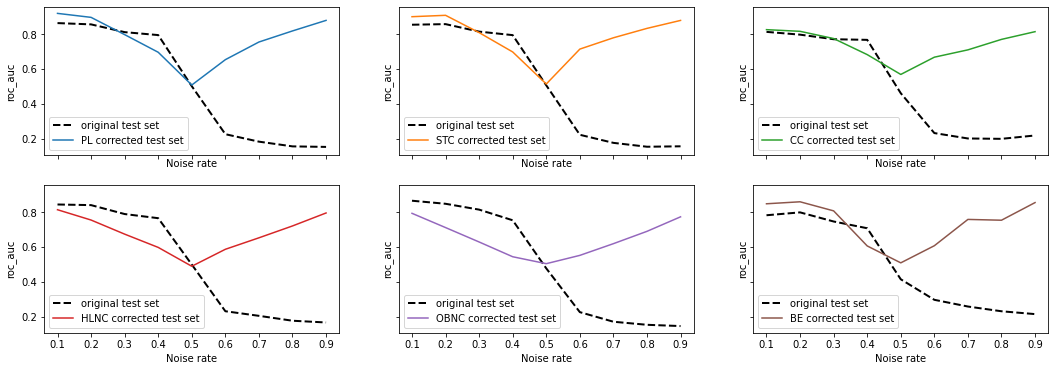

In [ ]:
for metric in pred_metrics:
    show_corrected_test_performance('random', metric)

### Group-dependant noise

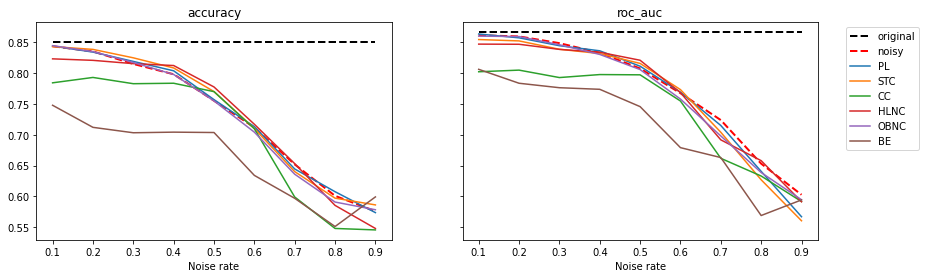

In [ ]:
show_all_metrics_pred('flip', 'original')

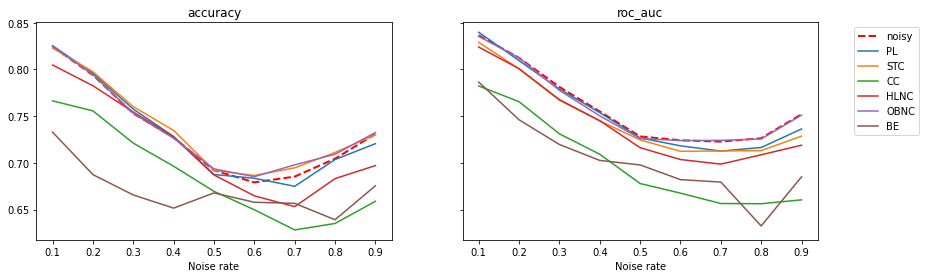

In [ ]:
show_all_metrics_pred('flip', 'noisy')

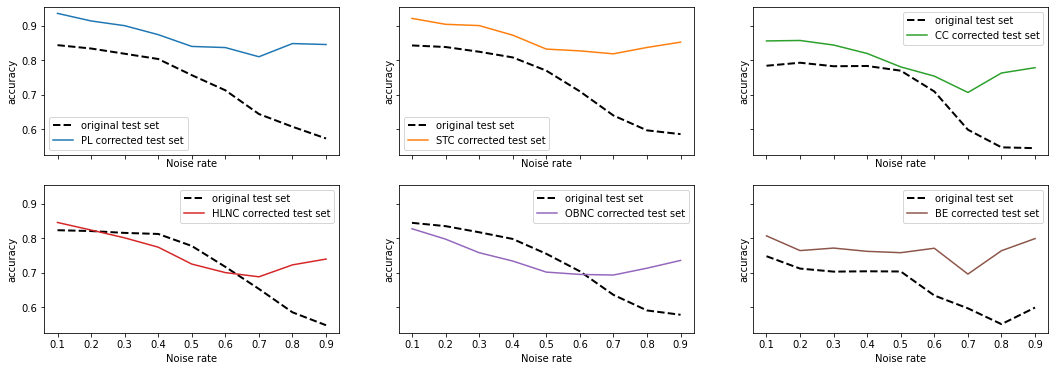

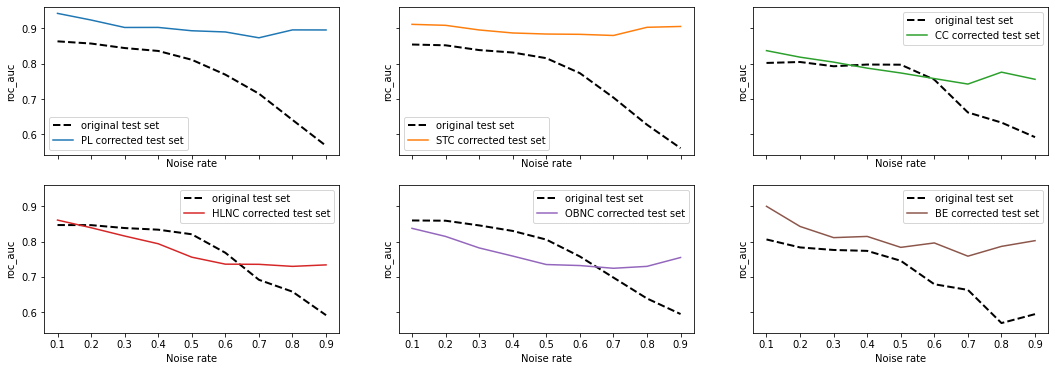

In [ ]:
for metric in pred_metrics:
    show_corrected_test_performance('flip', metric)

In [ ]:
# show_all_test_sets_aggr('flip', 'roc_auc')
# show_all_test_sets_aggr('flip', 'accuracy')

### Positive bias noise

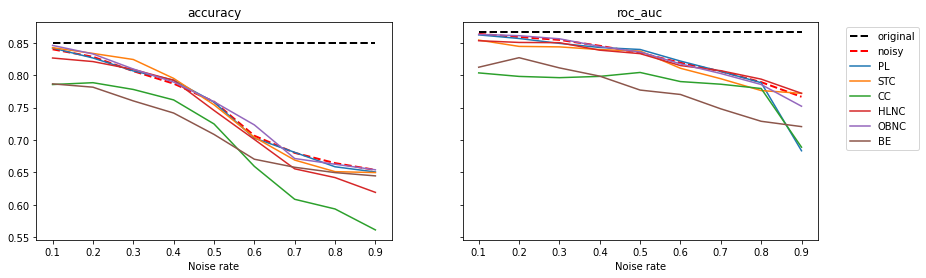

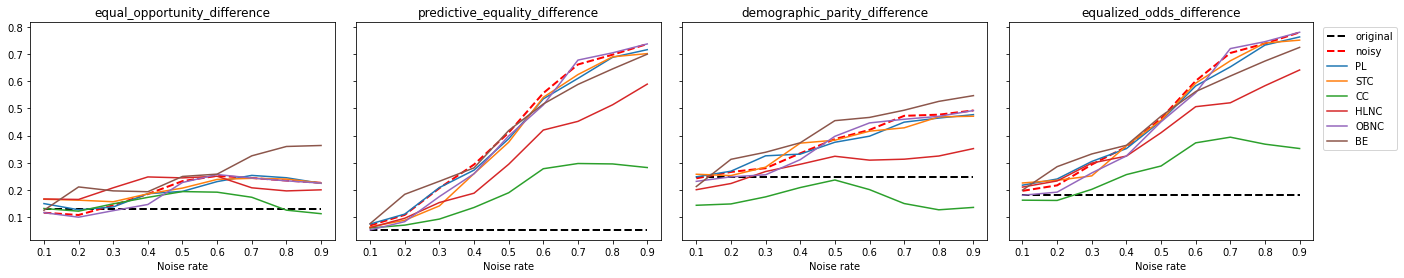

In [ ]:
show_all_metrics_pred('bias', 'original')
show_all_metrics_fair('bias', 'original')

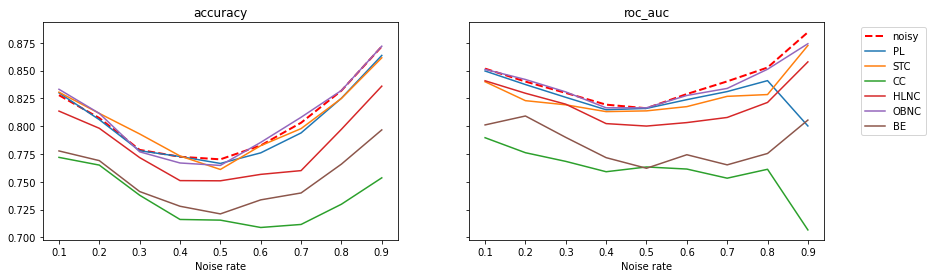

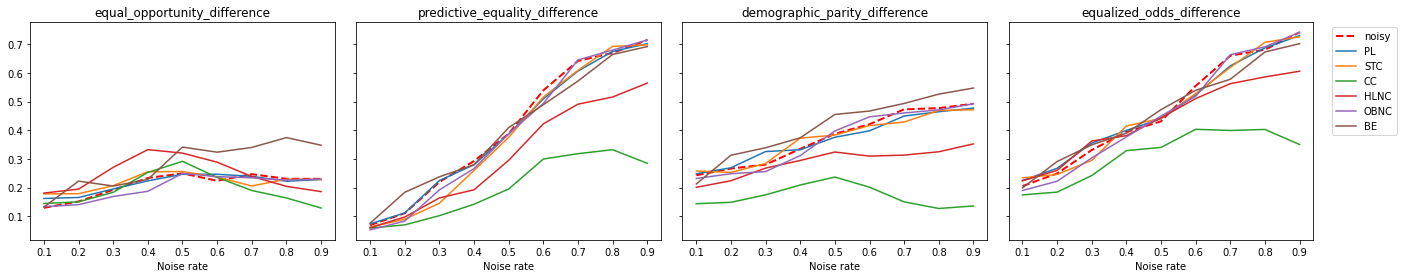

In [ ]:
show_all_metrics_pred('bias', 'noisy')
show_all_metrics_fair('bias', 'noisy')

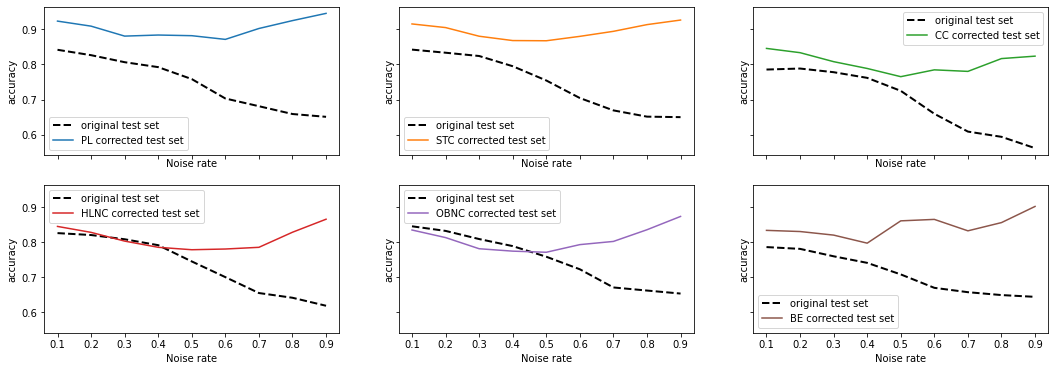

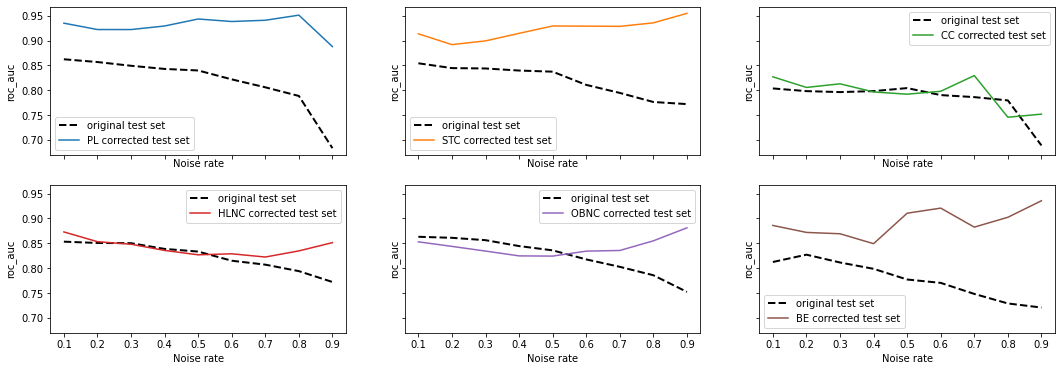

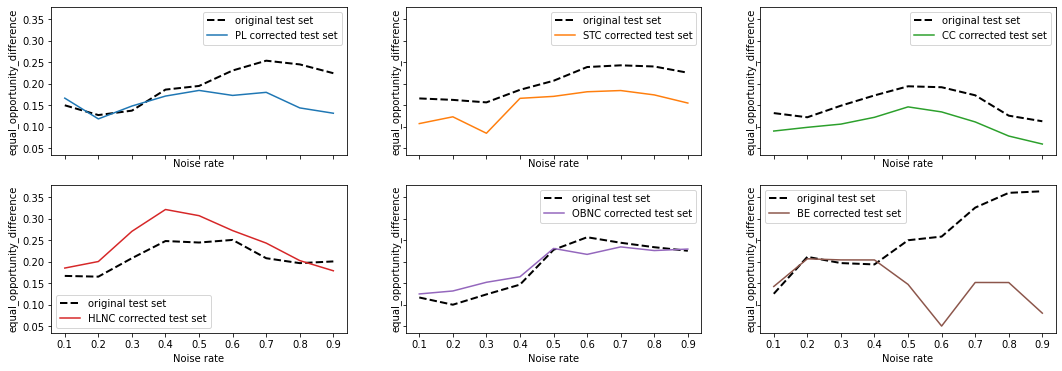

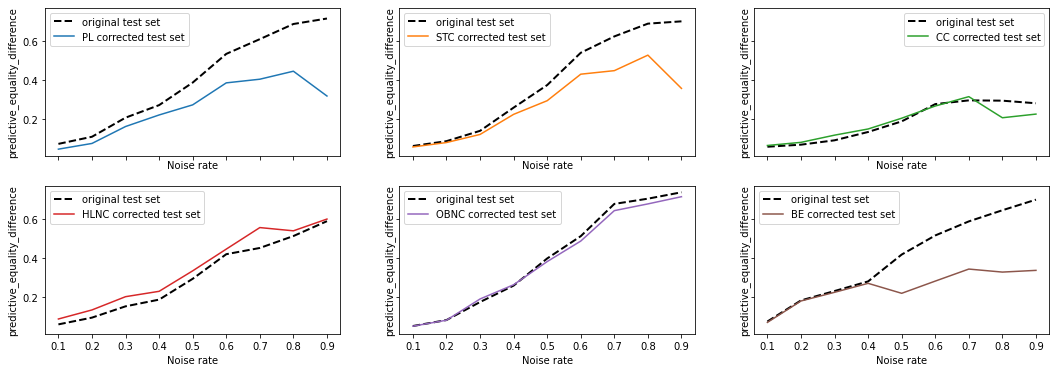

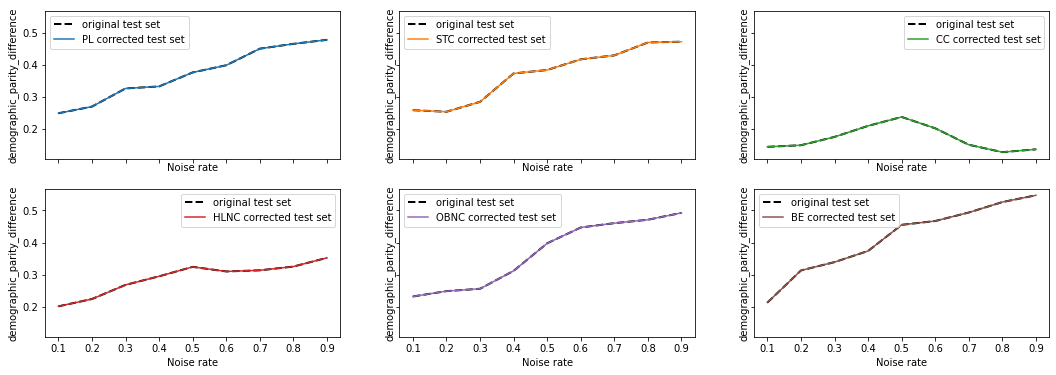

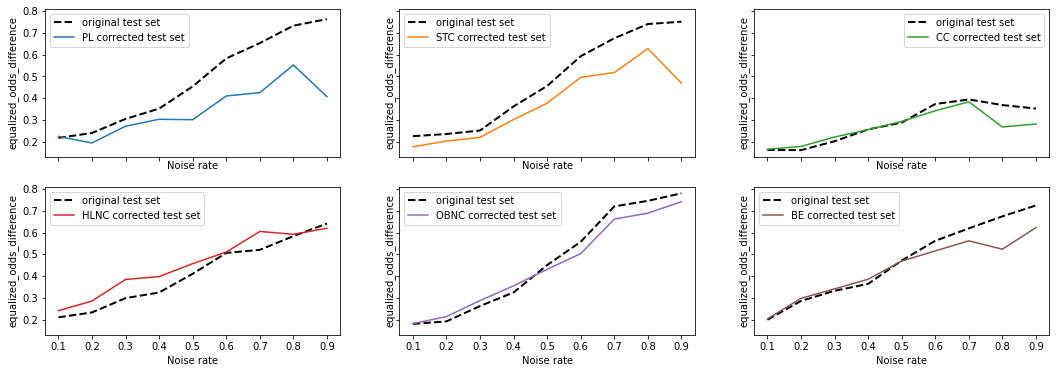

In [ ]:
for metric in metrics:
    show_corrected_test_performance('bias', metric)

In [ ]:
# show_all_test_sets_aggr('bias', 'roc_auc')
# show_all_test_sets_aggr('bias', 'accuracy')

In [ ]:
# show_all_test_sets_aggr('bias', 'demographic_parity_difference')
# show_all_test_sets_aggr('bias', 'equal_opportunity_difference')
# show_all_test_sets_aggr('bias', 'equalized_odds_difference')
# show_all_test_sets_aggr('bias', 'predictive_equality_difference')

### Balanced bias noise

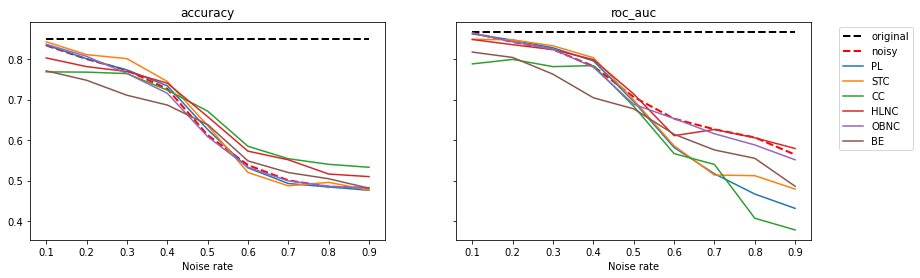

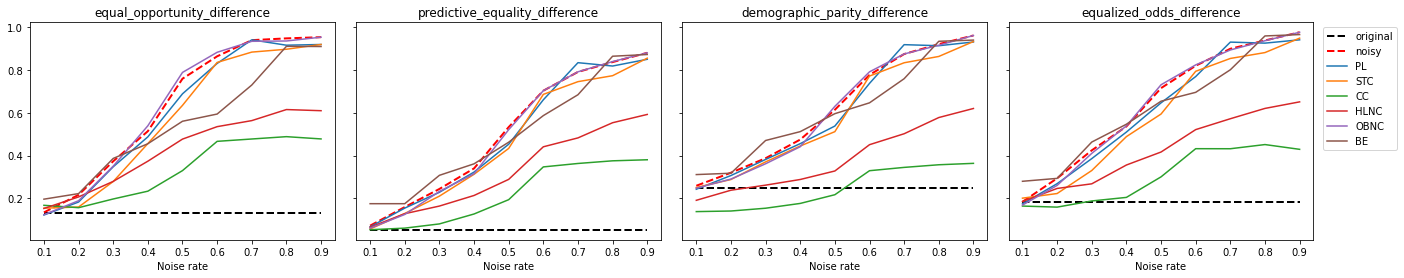

In [ ]:
show_all_metrics_pred('balanced_bias', 'original')
show_all_metrics_fair('balanced_bias', 'original')

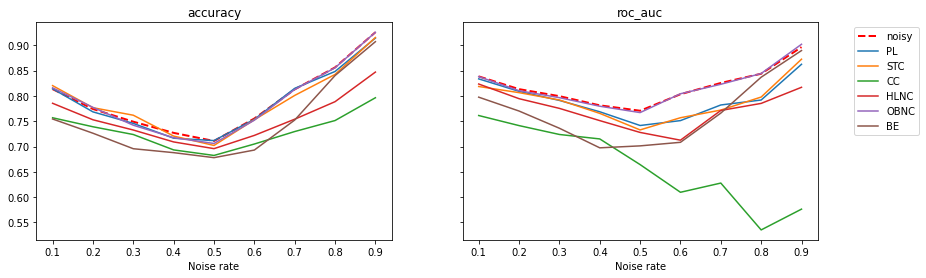

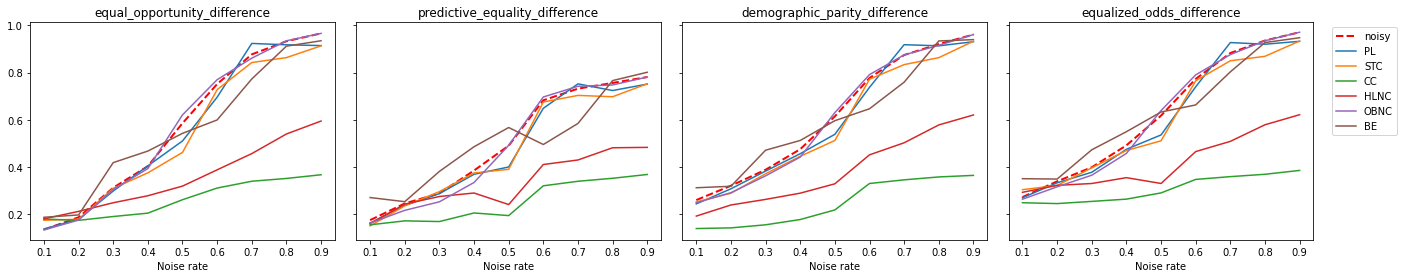

In [ ]:
show_all_metrics_pred('balanced_bias', 'noisy')
show_all_metrics_fair('balanced_bias', 'noisy')

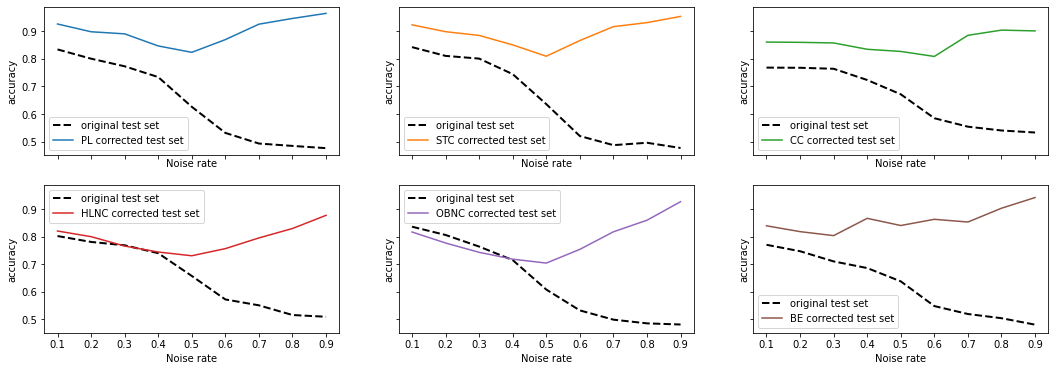

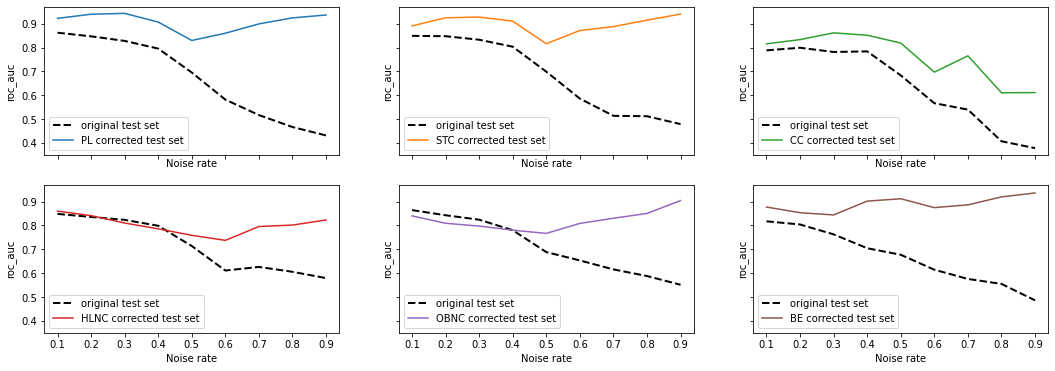

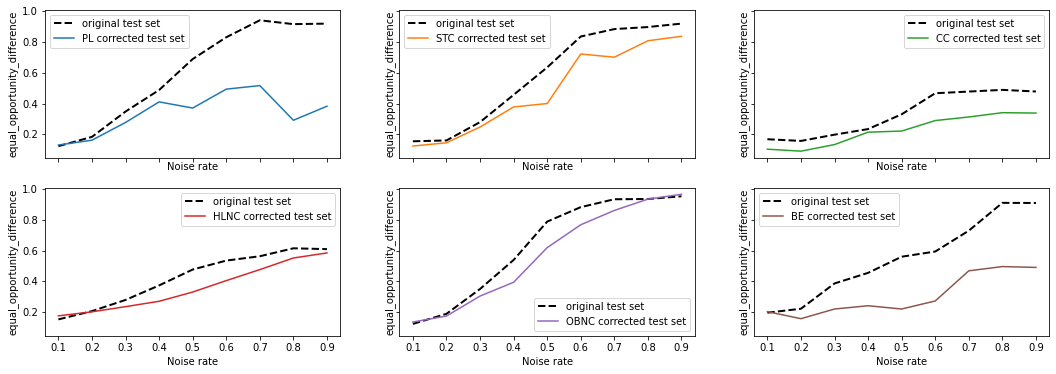

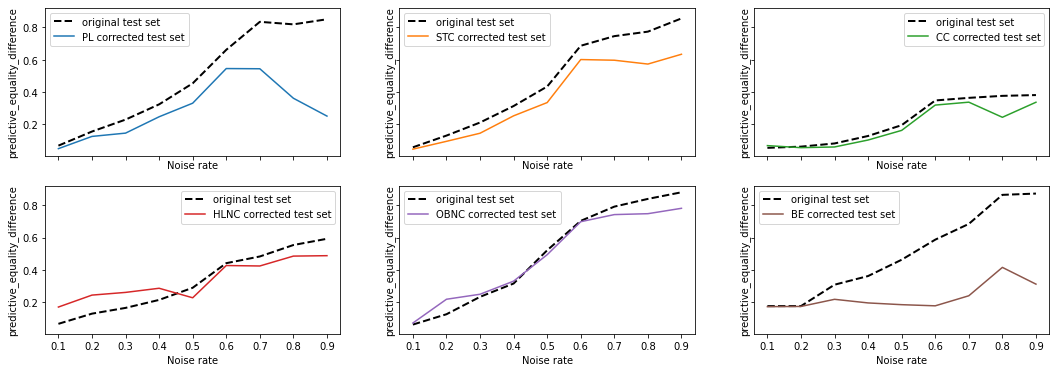

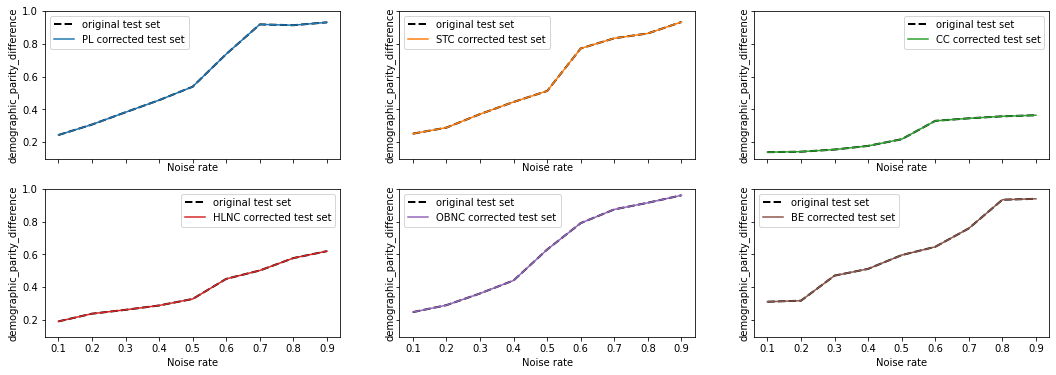

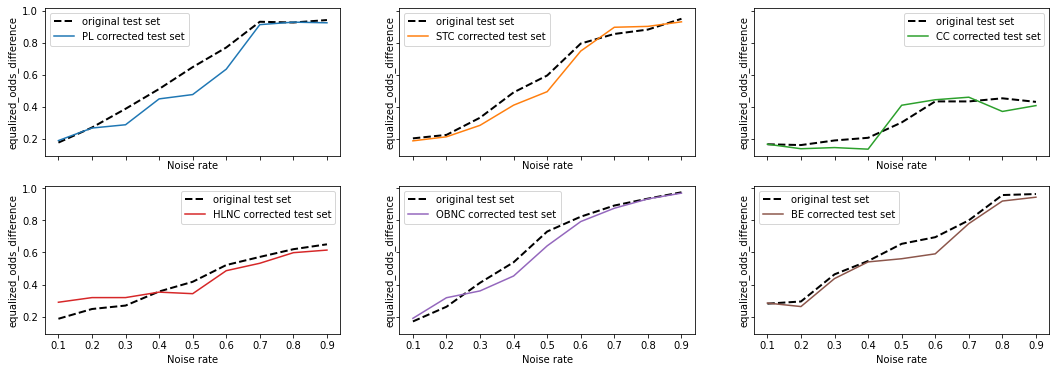

In [ ]:
for metric in metrics:
    show_corrected_test_performance('balanced_bias', metric)

In [ ]:
noise_type_colors = {
    'random': 'tab:blue',
    'flip': 'tab:orange',
    'bias': 'tab:green',
    'balanced_bias': 'tab:red'
}

def show_noise_types_performance(alg, test_set, metric, ax, nt):
    results = {noise_type: {noise_rate: [] for noise_rate in nr} for noise_type in nt}
    if test_set == 'original':
        results['original'] = {noise_rate: [] for noise_rate in nr}

    for exp in experiments:
        for noise_type in nt:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set)]
            for noise_rate in nr:
                results[noise_type][noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'noisy')][f'metrics.{metric}'].values[0])
        
        if test_set == 'original':
            for noise_rate in nr:
                results['original'][noise_rate].append(run.loc[(run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'original')][f'metrics.{metric}'].values[0])
        

    if test_set == 'original':       
        ax.plot(nr, [np.mean(results['original'][noise_rate]) for noise_rate in nr], label='original', color='black', linestyle='--', linewidth=2)
    
    for noise_type in nt:
        ax.plot(nr, [np.mean(results[noise_type][noise_rate]) for noise_rate in nr], label=noise_type, c=noise_type_colors[noise_type])

    #ax.set_title(f'Correction algorithm: {alg}')
    ax.set_title(f'{metric}')
    ax.set_xlabel('Noise rate')
    ax.set_ylabel(f'{metric}')

In [ ]:
def show_metric_alg(test_set, metric):
    fig = plt.figure(figsize=(18, 7))
    axs = fig.subplots(2, 3, sharey=True, sharex=True)

    for i in range(6):
        show_noise_types_performance(algorithms[i], test_set, metric, axs[i // 3, i % 3], noise_types)

    
    axs[1, 2].legend(bbox_to_anchor=(1.4, 1.5))
    plt.subplots_adjust(wspace=0.07)
    plt.show()

In [ ]:
def show_pred_metrics(test_set, alg):
    fig = plt.figure(figsize=(12, 4))
    axs = fig.subplots(1, 2, sharey=True)

    for i in range(2):
        show_noise_types_performance(alg, test_set, pred_metrics[i], axs[i], noise_types)

    
    axs[1].legend(bbox_to_anchor=(1, 1))
    plt.subplots_adjust(wspace=0.07)
    plt.show()

In [ ]:
def show_fair_metrics(test_set, alg):
    fig = plt.figure(figsize=(20, 4))
    axs = fig.subplots(1, 4, sharey=True)

    for i in range(4):
        show_noise_types_performance(alg, test_set, fair_metrics[i], axs[i], ['bias', 'balanced_bias'])

    
    axs[3].legend(bbox_to_anchor=(1, 1))
    plt.subplots_adjust(wspace=0.07)
    plt.show()

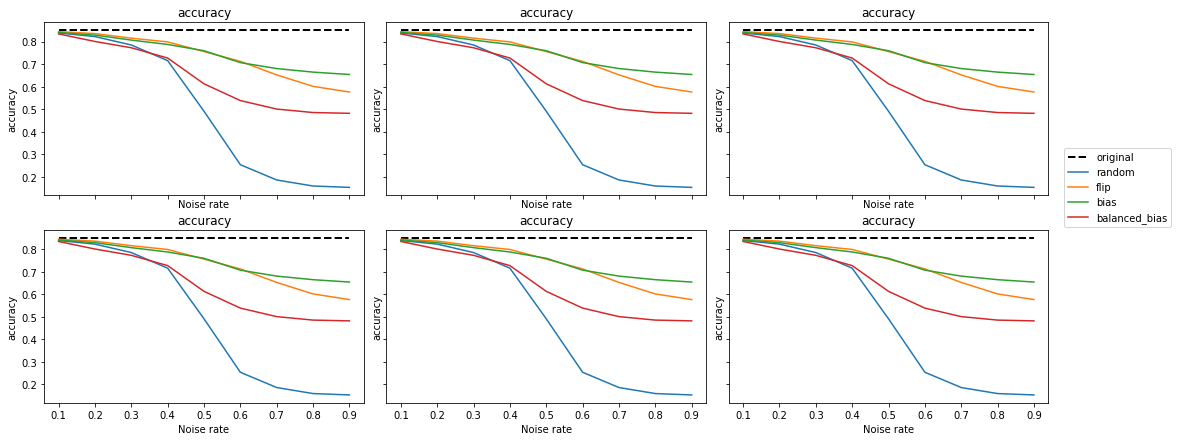

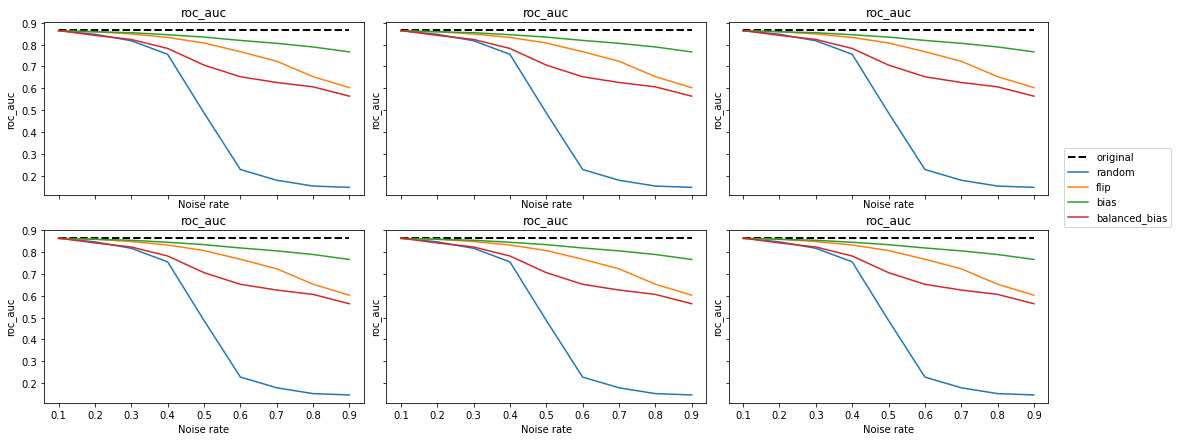

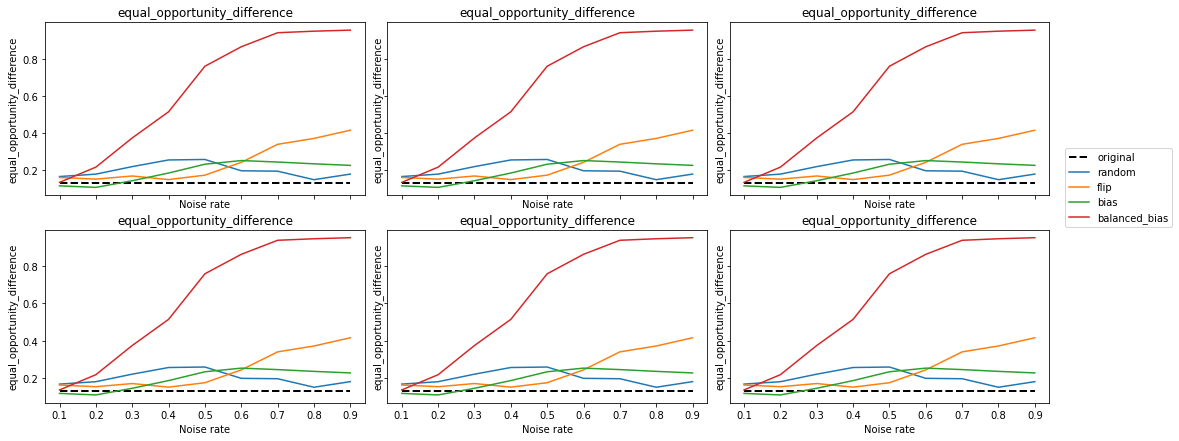

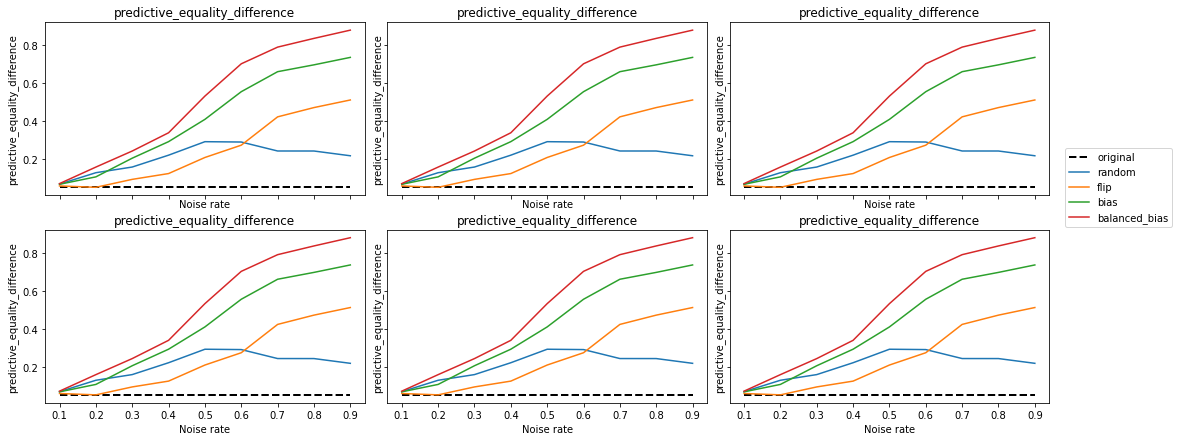

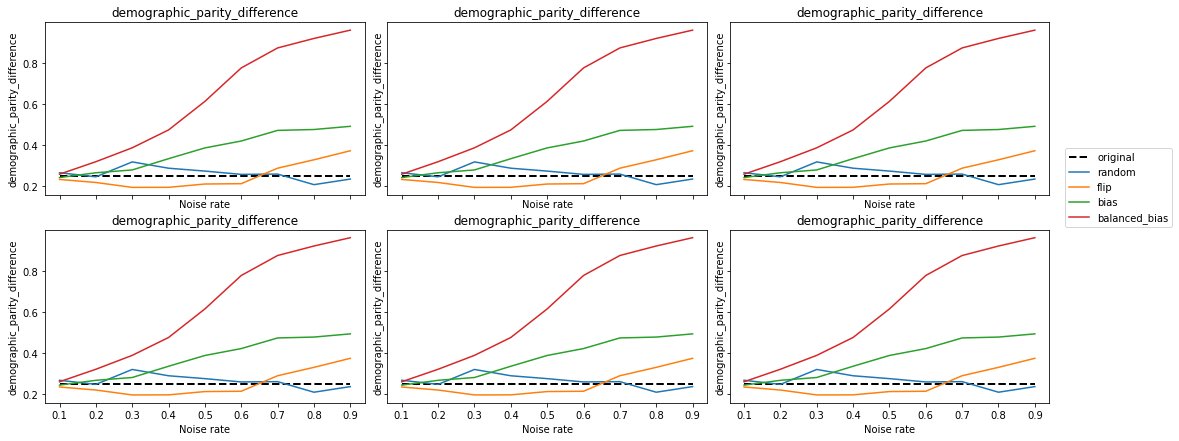

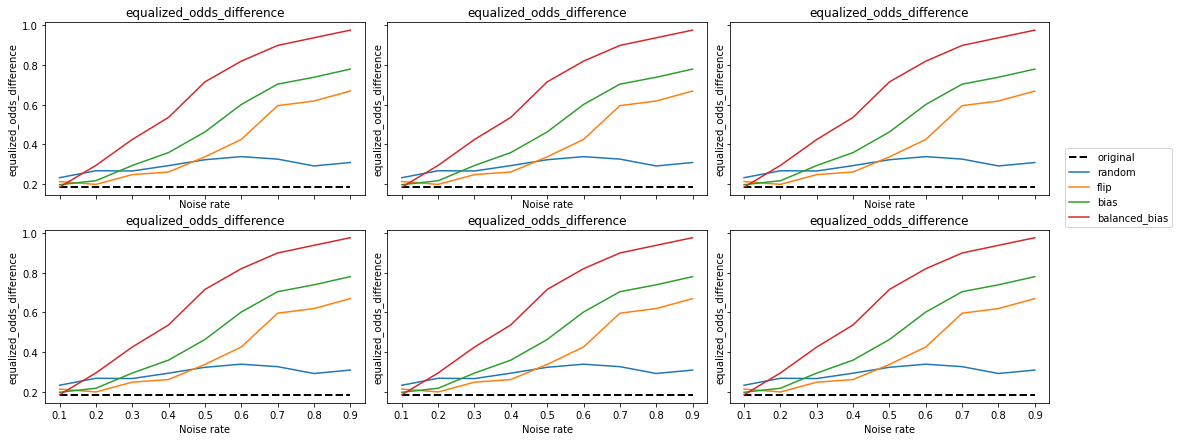

In [ ]:
for metric in metrics:
    show_metric_alg('original', metric)

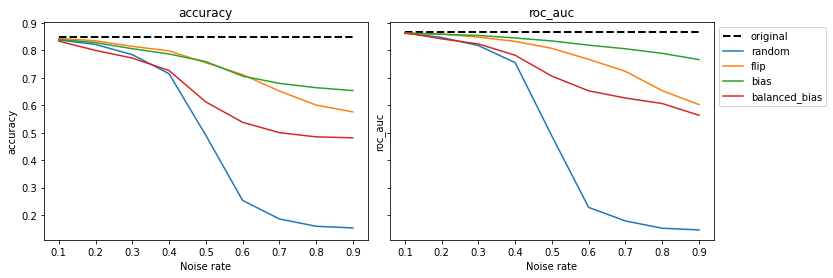

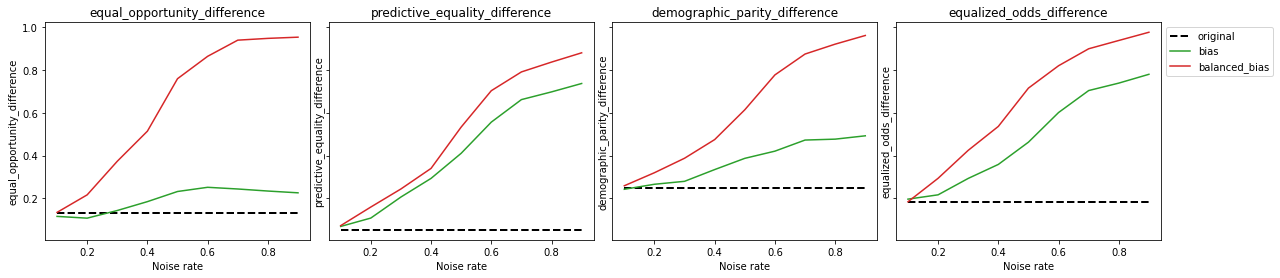

In [ ]:
show_pred_metrics('original', 'PL')
show_fair_metrics('original', 'PL')

## Accuracy/Fairness trade-offs

In [ ]:
def show_trade_off(noise_type, pred_metric, fair_metric, test_set, noise_rate, ax):
    if test_set == 'original':
        train_sets = ['original', 'noisy']
    else:
        train_sets = ['noisy']
    for train_set in train_sets:
        predictive_performance = []
        fairness = []
        for exp in experiments:
            run = runs[f'{exp}_PL']
            run = run.loc[(run['params.noise_type'] == noise_type) & (run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == train_set)]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])

        if train_set == 'original':
            c = 'black'
        else:
            c = 'r'
        
        ax.scatter(np.mean(fairness), np.mean(predictive_performance), label=train_set, color=c, marker='x', s=100)
        ax.axvline(x=np.mean(fairness), alpha=0.2, color=c, linestyle='--')
        ax.axhline(y=np.mean(predictive_performance), alpha=0.2, color=c, linestyle='--')
        

    for alg in algorithms:
        predictive_performance = []
        fairness = []
        for exp in experiments:
            run = runs[f'{exp}_{alg}']
            run = run.loc[(run['params.noise_type'] == 'bias') & (run['tags.test_set'] == test_set) & (run['params.noise_rate'] == noise_rate) & (run['tags.train_set'] == 'corrected')]
            predictive_performance.append(run[f'metrics.{pred_metric}'].values[0])
            fairness.append(run[f'metrics.{fair_metric}'].values[0])
        ax.scatter(np.mean(fairness), np.mean(predictive_performance), label=alg, s=40)

    ax.set_title(f'{test_set} test set')
    ax.set_xlabel(fair_metric)
    ax.set_ylabel(pred_metric)

In [ ]:
def show_trade_off_all_test_sets(pred_metric, fair_metric, noise_rate, noise_type):
    test_sets = ['original', 'noisy'] #, 'corrected']

    fig = plt.figure(figsize=(20, 5))
    axs = fig.subplots(1, 2, sharey=True, sharex=True)

    for i in range(2):
        show_trade_off(noise_type, pred_metric, fair_metric, test_sets[i], noise_rate, axs[i])

    axs[0].legend(bbox_to_anchor=(2.4, 1))
    plt.suptitle(f'{pred_metric} vs {fair_metric} ({noise_rate} noise rate)', fontsize=16, y=1.05)
    plt.show()

In [ ]:
def show_trade_off_all_metrics(noise_type, noise_rate, test_set):
    fig = plt.figure(figsize=(25, 8))
    axs = fig.subplots(2, 4, sharey=True, sharex=True)

    for i in range(8):
        row = i // 4
        col = i % 4
        show_trade_off(noise_type, pred_metrics[row], fair_metrics[col], test_set, noise_rate, axs[row, col])

    axs[1, 3].legend(bbox_to_anchor=(1, 1.5))
    #plt.suptitle(f'{pred_metric} vs {fair_metric} ({noise_rate} noise rate)', fontsize=16, y=1.05)
    plt.subplots_adjust(wspace=0.07)
    plt.show()

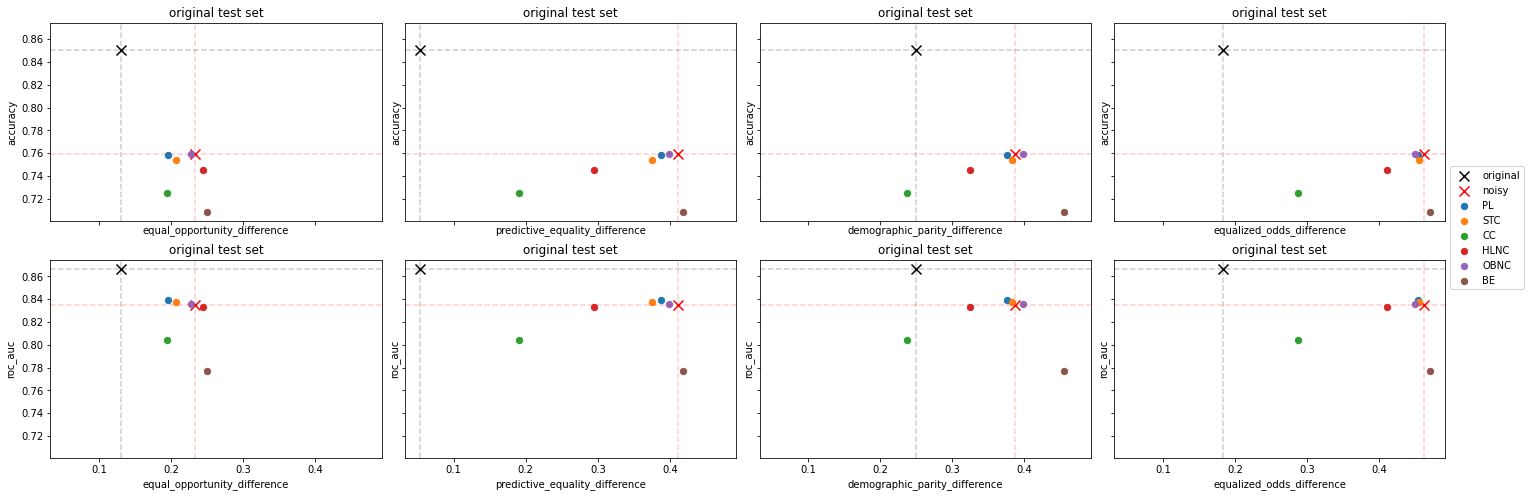

In [ ]:
noise_rate = 0.5
show_trade_off_all_metrics('bias', noise_rate, 'original')

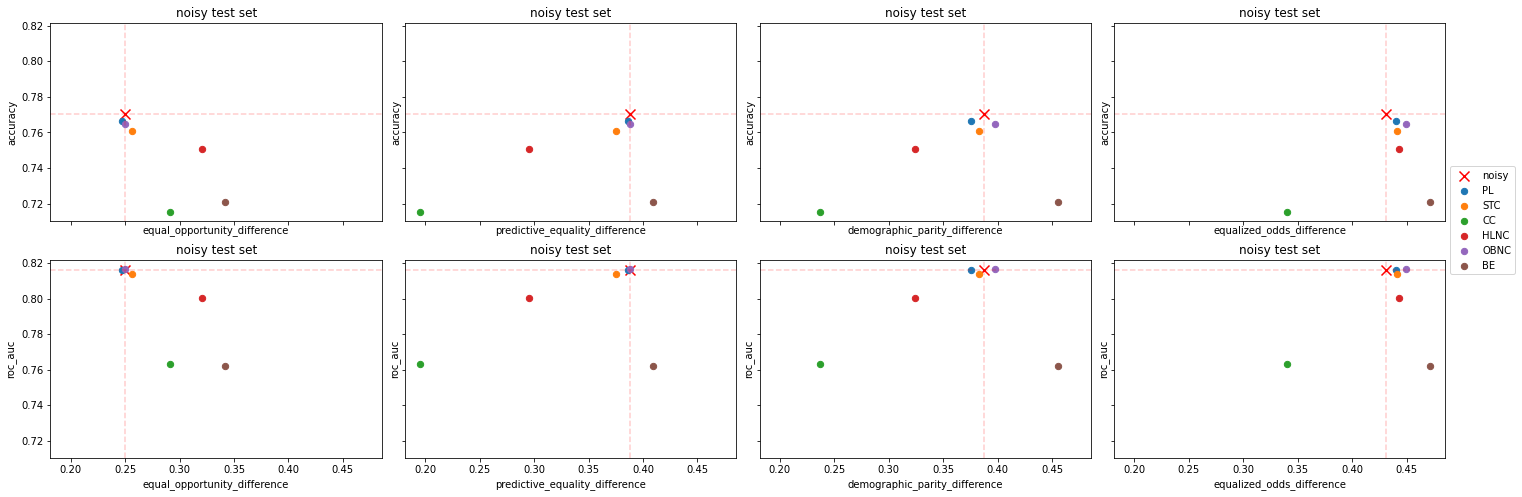

In [ ]:
noise_rate = 0.5
show_trade_off_all_metrics('bias', noise_rate, 'noisy')

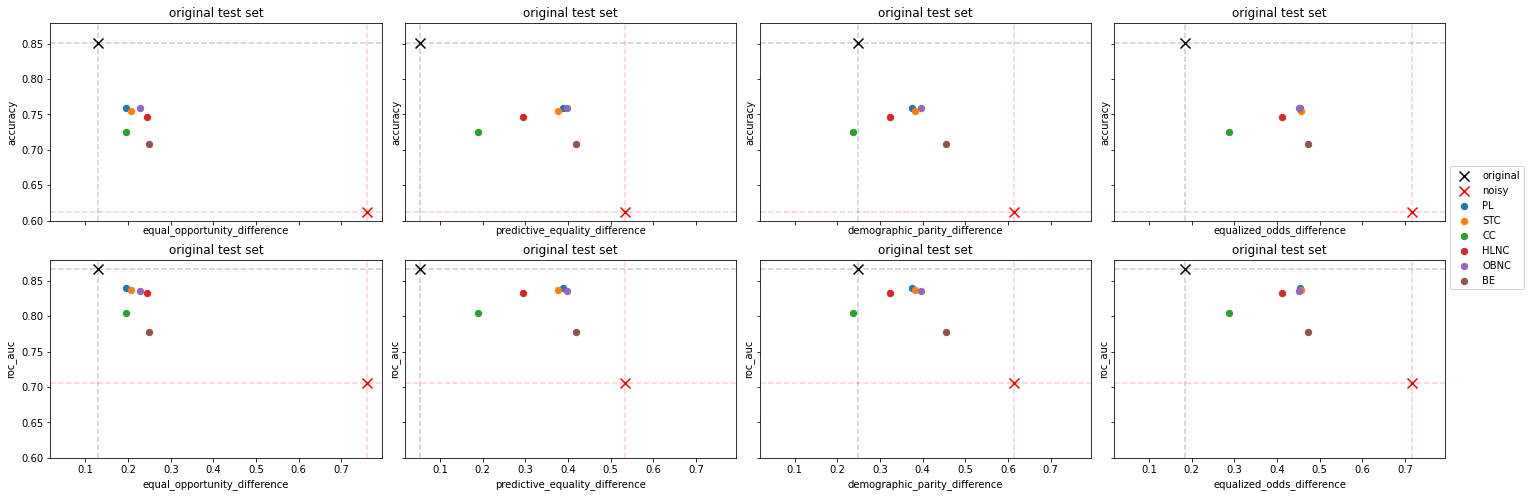

In [ ]:
noise_rate = 0.5
show_trade_off_all_metrics('balanced_bias', noise_rate, 'original')

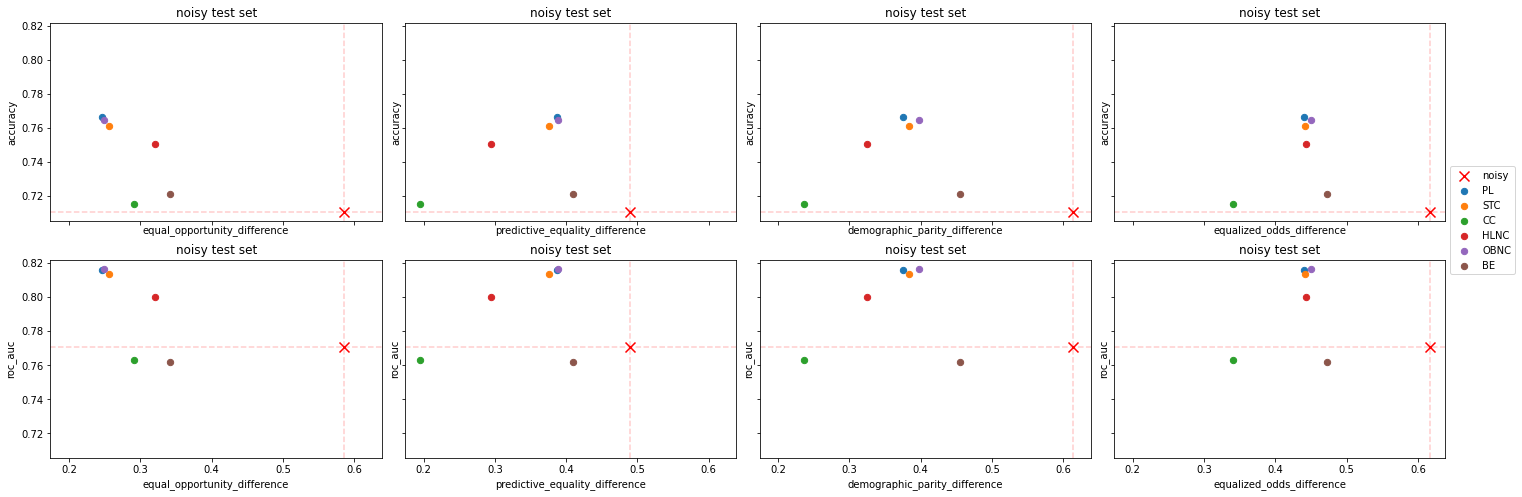

In [ ]:
noise_rate = 0.5
show_trade_off_all_metrics('balanced_bias', noise_rate, 'noisy')

In [ ]:
# show_trade_off_all_test_sets('accuracy', 'demographic_parity_difference', noise_rate)
# show_trade_off_all_test_sets('accuracy', 'equalized_odds_difference', noise_rate)
# show_trade_off_all_test_sets('accuracy', 'equal_opportunity_difference', noise_rate)
# show_trade_off_all_test_sets('accuracy', 'predictive_equality_difference', noise_rate)

In [ ]:
# show_trade_off_all_test_sets('roc_auc', 'demographic_parity_difference', noise_rate)
# show_trade_off_all_test_sets('roc_auc', 'equalized_odds_difference', noise_rate)
# show_trade_off_all_test_sets('roc_auc', 'equal_opportunity_difference', noise_rate)
# show_trade_off_all_test_sets('roc_auc', 'predictive_equality_difference', noise_rate)